### Siamese network on mnist
Predict which number is higher

In [1]:
#lasagne imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import lasagne
import lasagne.layers.dnn

import theano
import theano.tensor as T

from collections import OrderedDict

from IPython.display import clear_output

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
from datasets.load_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

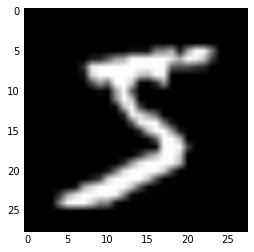

In [3]:
plt.imshow(X_train[0,0], cmap='gray')

In [4]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        ts = targets[excerpt]
        ohe_labels = OneHotEncoder(10, sparse=False).fit_transform(ts[:,None])
        yield inputs[excerpt], targets[excerpt]#ohe_labels

In [5]:
#batch generator classic
def batch_gen_classic(batch_size, X, y):
    num_samps  = len(X)
    assert num_samps == len(y)
    
    inds = np.random.randint(low=0, high=num_samps-1, size=batch_size)
    
    inputs = X[inds]
    labels = y[inds]
    ohe_labels = OneHotEncoder(10, sparse=False).fit_transform(labels[:,None])

    return inputs, ohe_labels
    
#batch generator pairwise perfect
def batch_gen_pc(batch_size, X, y):
    num_samps  = len(X)
    assert num_samps == len(y)
    
    inds = np.random.randint(low=0, high=num_samps-1, size=batch_size)
    
    inputs = X[inds]
    labels = y[inds]
    
    #turn the labels into pc results
    pc_labels = labels[0::2] < labels[1::2] #where 1st of pair is bigger than 2nd
    
    return inputs, pc_labels.astype(int)

#batch generator pairwise btl
def batch_gen_pcbtl():
    pass

In [9]:
#build mlp
def mlp_feat_extract(X):
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

    net['dense1'] = lasagne.layers.DenseLayer(net['input'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)

    net['dense2'] = lasagne.layers.DenseLayer(net['dense1'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)

    net['dense3'] = lasagne.layers.DenseLayer(net['dense2'], 100, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)
    
    net['softmax'] = lasagne.layers.DenseLayer(net['dense3'], 10, \
                                                   nonlinearity=lasagne.nonlinearities.softmax)
    return net

def cnn_feat_extract(X):
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

    
    
    ###----
    net['conv1'] = lasagne.layers.Conv2DLayer(net['input'], num_filters=32, filter_size=(5,5), \
                                               nonlinearity=lasagne.nonlinearities.rectify)
    net['pool1'] = lasagne.layers.MaxPool2DLayer(net['conv1'], pool_size=(2, 2))
    ###----
    
    
    ###-----
    net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=32, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv3'] = lasagne.layers.Conv2DLayer(net['conv2'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv4'] = lasagne.layers.Conv2DLayer(net['conv3'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['pool2'] = lasagne.layers.MaxPool2DLayer(net['conv4'], pool_size=(2, 2))
    ###---
    
    
    net['fc1'] = lasagne.layers.DenseLayer(net['pool2'], num_units=256, \
                                           nonlinearity=lasagne.nonlinearities.rectify)
    
    net['fc2'] = lasagne.layers.DenseLayer(net['fc1'], num_units=128, \
                                           nonlinearity=lasagne.nonlinearities.rectify)

    return net

def add_siamese(net):
    #concatenate representations (halving the batch (i.e. zeroth) dimension)
    layer_list = [net[layer] for layer in net]
    current_shape = lasagne.layers.get_output_shape(layer_list[-1])
    
    new_shape = list(current_shape)
    new_shape[0] = -1 #free the batch dimension
    new_shape[1] = new_shape[1]*2 # double the 1st
    new_shape = tuple(new_shape)

    net['fusion'] = lasagne.layers.ReshapeLayer(layer_list[-1], new_shape)
    
    return net

def add_softmax(net, num_units=10):
    #concatenate representations (halving the batch (i.e. zeroth) dimension)
    layer_list = [net[layer] for layer in net]
    
    #add softmax
    net['softmax'] = lasagne.layers.DenseLayer(layer_list[-1], num_units=num_units, \
                                               nonlinearity=lasagne.nonlinearities.softmax)
    
    return net

#explicit btl model
class BTLLayer(lasagne.layers.Layer):
    #takes a two column input - each column contains the value on some scale
    def get_output_for(self, input, **kwargs):
        #calculate the probs of pairwise comparison win
        total_col = input[:,0] + input[:,1]
        total_mat = T.extra_ops.repeat(x=total_col[:,None], repeats=2, axis=1)
        return input/total_mat

def add_btl(net):
    layer_list = [net[layer] for layer in net]
    net['reg'] = lasagne.layers.DenseLayer(layer_list[-1], num_units=1, \
                                               nonlinearity=lasagne.nonlinearities.sigmoid)
    
    #combine across 0th dimension 
    net['fusion'] = lasagne.layers.ReshapeLayer(net['reg'], (-1, 2)) #now has 2 columns
    
    #calc the btl probs
    net['out'] = BTLLayer(net['fusion'])
    return net

In [10]:
#calc output of network
#initialise inputs and outputs
X = T.tensor4('X')
y = T.ivector('y') # <- need to specify the dim of the inputs and outputs

#build and calc the net output
net = cnn_feat_extract(X)
net = add_btl(net)
#net = add_siamese(net)
#net = add_softmax(net, num_units=2)

layer_list = [net[layer] for layer in net]
full_output = lasagne.layers.get_output(layer_list)
y_pred = full_output[-1]

#calc the loss
loss = lasagne.objectives.categorical_crossentropy(y_pred, y)
loss = loss.mean() #mean over the batch
acc = lasagne.objectives.categorical_accuracy(y_pred, y)
acc = acc.mean()

#get params and backprop loss across
params = lasagne.layers.get_all_params(layer_list[-1], trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=.01, momentum=0.9)
#updates = lasagne.updates.sgd(loss, params, learning_rate=.00001)

#compile the functions
from theano.compile.nanguardmode import NanGuardMode

check_fn = theano.function(inputs = [X], outputs=full_output, allow_input_downcast=True)
train_fn = theano.function(inputs = [X, y], outputs=loss, updates=updates, allow_input_downcast=True)
pass_fn = theano.function(inputs=[X, y], outputs=[loss, acc, y_pred], allow_input_downcast=True) # <- for passing test data

### Train (standard/classic)

In [ ]:
num_epochs = 100
epoch_loss_hist = []
for ep in xrange(num_epochs):
    train_batches = 0
    train_loss = 0
    for Xb, yb in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        train_loss += train_fn(Xb, yb) # <- trains the network
        train_batches += 1

    #forward pass over validation data for reporting
    val_loss = 0
    val_batches = 0
    val_acc = 0
    for Xb, yb in iterate_minibatches(X_val, y_val, 500, shuffle=True):
        vl, va, y_pred = pass_fn(Xb, yb) # <- trains the network
        val_loss += vl
        val_batches += 1
        val_acc += va
        
    #report the results after each epoch
    epoch_loss_hist.append({'train': train_loss/float(train_batches), 'val': val_loss/float(val_batches)})
    print 'epoch {0} results: train loss of {1}, val acc of {2}'.format(ep, 
                                                                         train_loss/float(train_batches),
                                                                         val_acc/float(val_batches))
                                                                         #val_loss/float(val_batches))

### Train (siamese)

In [11]:
num_epochs = 100
batches_per_epoch = 100
epoch_loss_hist = []
for ep in xrange(num_epochs):
    train_batches = 0
    train_loss = 0
    for _ in xrange(batches_per_epoch):
        Xb, yb = batch_gen_pc(500, X_train, y_train)
        train_loss += train_fn(Xb, yb) # <- trains the network
        train_batches += 1

    #forward pass over validation data for reporting
    val_loss = 0
    val_batches = 0
    val_acc = 0
    for _ in xrange(3):
        Xb, yb = batch_gen_pc(500, X_train, y_train)
        vl, va, y_pred = pass_fn(Xb, yb) # <- trains the network
        val_loss += vl
        val_batches += 1
        val_acc += va
        
    #report the results after each epoch
    clear_output()
    epoch_loss_hist.append({'train': train_loss/float(train_batches), 'val': val_loss/float(val_batches)})
    print 'epoch {0} results: train loss of {1}, val acc of {2}'.format(ep, 
                                                                         train_loss/float(train_batches),
                                                                         val_acc/float(val_batches))
                                                                         #val_loss/float(val_batches))

epoch 99 results: train loss of 0.11194749143, val acc of 0.948


In [12]:
X_examples, labs = batch_gen_pc(100, X_val, y_val)
full_output = check_fn(X_examples)

[ 1.  0.]
[  9.26622748e-02   3.52373384e-08]


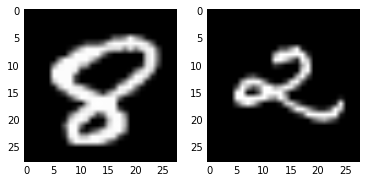

In [18]:
comp = 5
indl = comp*2
indr = 1+(comp*2)
f, ax = plt.subplots(1, 2)
ax[0].imshow(full_output[0][indl,0], cmap='gray')
ax[1].imshow(full_output[0][indr,0], cmap='gray')
print np.round(full_output[-1][comp])
print full_output[-2][comp]

### TODO - create function which takes in an image and spits out the regression value
can just use output from check_fn (full_output[-2]) iterate across examples in the val set, collecting stats, plot scatter plot of labels vs the regressed values